# Conformal Prediction for Regression

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
def std_radius(p: float) -> jax.Array:
    """
    Convert central coverage p (0 < p < 1) into ±n standard deviations
    for a standard normal. Vectorised for arbitrary-shape arrays.
    """
    p: jax.Array = jnp.asarray(p)
    if jnp.any((p <= 0) | (p >= 1)):
        raise ValueError("p must lie strictly between 0 and 1")
    return jnp.sqrt(2.0) * jax.scipy.special.erfinv(p)

# Generate some example data

In [18]:
alpha_lo = 0.1
alpha_hi = 0.9
alpha = 0.2 # miscoverage rate = alpha_lo + (1 - alpha_hi)

noise_amp = 3.0

n_train = 2000
n_calib = 500

In [19]:
def f(x: jax.Array):
    return x**3 - 5*x**2 + 3*x - 5

def f_noised(x: jax.Array, noise_rng: jax.Array, noise_amp: float = noise_amp) -> jnp.ndarray:
    noise_term = noise_amp * jax.random.normal(key=noise_rng)
    return f(x) + jnp.sqrt(x) * noise_term

f_batch = jax.vmap(f)
f_noise_batch = jax.vmap(f_noised)

n_total = n_train + n_calib
x_sample_rng = jax.random.key(42)
x = jax.random.uniform(x_sample_rng, shape=(n_total, 1), minval=0, maxval=5)
x = jnp.sort(x, axis=0) # sort here to make plotting easier

# generate noisy and true values of the function
noise_rng = jax.random.split(jax.random.key(42), n_total)
y_true = f_batch(x)
y_noised = f_noise_batch(x, noise_rng)

# split into training and calibration data for conformalisation
# since the data is sorted, sort the keys too. Sorting the data is weird, but
# we're not doing minibatches so doesn't cause any problems and makes plotting easier
all_indices = jnp.arange(n_total)
train_idx = jax.random.choice(x_sample_rng, all_indices, shape=(n_train,))
train_idx = jnp.sort(train_idx)
calib_idx = jnp.setdiff1d(all_indices, train_idx, assume_unique=True)
x_train = x[train_idx]
x_calib = x[calib_idx]

y_train_true = y_true[train_idx]
y_calib_true = y_true[calib_idx]

y_train_noised = y_noised[train_idx]
y_calib_noised = y_noised[calib_idx]



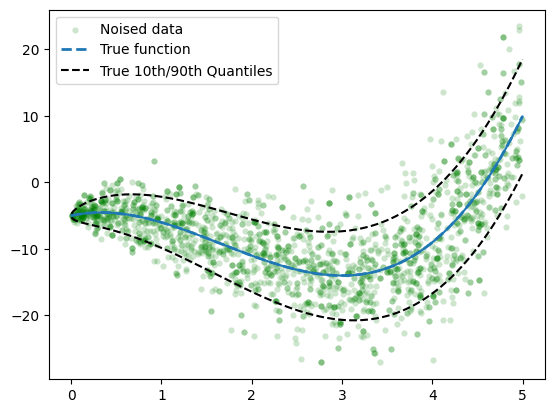

In [20]:
plt.scatter(x_train, y_train_noised, label='Noised data', c='g', alpha=0.2, linewidths=0, s=20)
plt.plot(x_train, y_train_true, label='True function', linestyle='--', linewidth=2.0, c='tab:blue')

# plot true quantiles
true_quantile_offset = jnp.sqrt(x_train) * noise_amp * std_radius(1 - alpha)

plt.plot(x_train,
         y_train_true + true_quantile_offset,
         color='k',
         linestyle='--',
         label=r'True 10th/90th Quantiles')
plt.plot(x_train,
         y_train_true - true_quantile_offset,
         color='k',
         linestyle='--',
         label='')  # suppress second legend entry
plt.plot(x_train, y_train_true)
plt.legend();

## Quantile Regression

First we train two quantile regression functions, f_lo and f_hi using the pinball loss. Given those functions, we can conformalise their predictions to get prediction sets

In [21]:
from functools import partial

def pinball_loss(y: jax.Array, y_hat: jax.Array, alpha_t: float):
    'Skewed loss used for quantile regression'
    z = y - y_hat
    return jnp.maximum(alpha_t * z, (alpha_t - 1) * z)

pb_loss_lo = jax.vmap(partial(pinball_loss, alpha_t = alpha_lo))
pb_loss_hi = jax.vmap(partial(pinball_loss, alpha_t = alpha_hi))

In [22]:
# define a simple neural net to fit to the data
import flax.linen as nn

class QuantileRegressor(nn.Module):
    hidden_dim = 32
    n_layers = 32
    @nn.compact
    def __call__(self, x):
            for _ in range(self.n_layers):
                x = nn.relu(nn.Dense(self.hidden_dim)(x))
            return nn.Dense(1)(x)

In [23]:
model = QuantileRegressor()

rng = jax.random.key(0)
rng_lo, rng_hi = jax.random.split(rng)


params_lo = model.init(rng_lo, x_train)
params_hi = model.init(rng_hi, x_train)

In [24]:
leaves = jax.tree_util.tree_leaves(params_lo)
n_params = sum([jnp.size(p) for p in leaves])
print(f"{2 * n_params:,} Total Parameters: ({n_params:,} per model)")

65,666 Total Parameters: (32,833 per model)


In [25]:
import optax

sched = optax.piecewise_constant_schedule(1e-3, {500: 0.5, 1000: 0.3, 1500: 0.3, 2000: 0.3})
tx = optax.adamw(sched, weight_decay=5e-4)
opt_state_lo = tx.init(params_lo)
opt_state_hi = tx.init(params_hi)

n_steps = 2000

@jax.jit
def loss_fn_lo(params) -> jax.Array:
    y_pred: jax.Array = model.apply(params, x_train) # type: ignore
    return pb_loss_lo(y_train_noised, y_pred).mean()

@jax.jit
def loss_fn_hi(params) -> jax.Array:
    y_pred: jax.Array = model.apply(params, x_train) # type: ignore
    return pb_loss_hi(y_train_noised, y_pred).mean()

for epoch in range(n_steps):
    loss_lo, grad_lo = jax.value_and_grad(loss_fn_lo)(params_lo)
    loss_hi, grad_hi = jax.value_and_grad(loss_fn_hi)(params_hi)
    updates_lo, opt_state_lo = tx.update(grad_lo, opt_state_lo, params=params_lo)
    updates_hi, opt_state_hi = tx.update(grad_hi, opt_state_hi, params=params_hi)
    params_lo = optax.apply_updates(params_lo, updates_lo)
    params_hi = optax.apply_updates(params_hi, updates_hi)

    if not epoch % 100:
        print(f'{str(epoch):>3} Loss : {loss_lo:.3f}, {loss_hi:.3f}')

  0 Loss : 7.696, 1.359
100 Loss : 1.072, 0.873
200 Loss : 1.061, 0.804
300 Loss : 0.920, 0.823
400 Loss : 0.865, 0.786
500 Loss : 0.799, 0.781
600 Loss : 0.761, 0.780
700 Loss : 0.760, 0.779
800 Loss : 0.764, 0.780
900 Loss : 0.752, 0.778
1000 Loss : 0.756, 0.771
1100 Loss : 0.749, 0.763
1200 Loss : 0.748, 0.762
1300 Loss : 0.747, 0.761
1400 Loss : 0.747, 0.762
1500 Loss : 0.746, 0.760
1600 Loss : 0.745, 0.757
1700 Loss : 0.745, 0.756
1800 Loss : 0.745, 0.756
1900 Loss : 0.745, 0.755


In [26]:
pred_lo = model.apply(params_lo, x_train)
pred_hi = model.apply(params_hi, x_train)

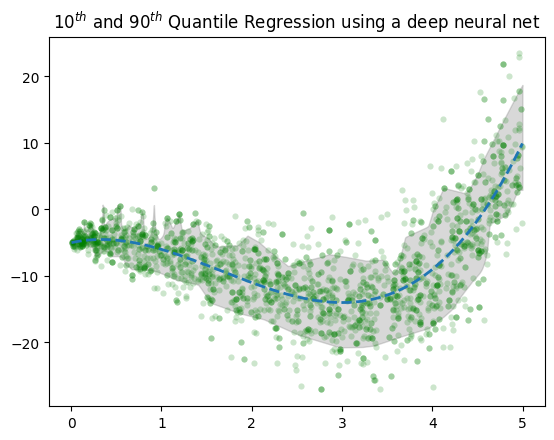

In [27]:
plt.scatter(x_train, y_train_noised, label='Noised data', c='g', alpha=0.2, linewidths=0, s=20)
# plt.plot(x_train, pred_lo, c='gray', alpha=0.6)
# plt.plot(x_train, pred_hi, c='gray', alpha=0.6)
plt.fill_between(x_train[:, 0], pred_lo[:, 0], pred_hi[:, 0], zorder=-10, color='gray', alpha=0.3)
plt.plot(x_train, y_train_true, label='True function', linestyle='--', linewidth=2.0)
plt.title(r"$10^{th}$ and $90^{th}$ Quantile Regression using a deep neural net");

## Now conformalise predictions using the calibration set!

Using the score function given by [Angelopoulos & Bates](https://people.eecs.berkeley.edu/~angelopoulos/publications/downloads/gentle_intro_conformal_dfuq.pdf), originally Romano 2019:

$$
s(x,y) \;=\; \max\bigl\{\hat t_{\alpha/2}(x) - y,\; y - \hat t_{1-\alpha/2}(x)\bigr\}.
$$

ie. For $\alpha=0.8$, the distance to the 10th and 90th quantiles given by the respective regression function $\hat{t}$. Note the score function is negative is y is within the bounds, and positive otherwise.

In [28]:
# conformity score - abs distance to y
def s(x_calib, y_calib):
    pred_lo = model.apply(params_lo, x_calib)
    pred_hi = model.apply(params_hi, x_calib)

    # now calculate the score using the elementwise maxium (not jnp.max!!)
    return jnp.maximum(pred_lo - y_calib, y_calib - pred_hi)

# now we can calculate q_hat, which will be used to adjust the regression prediction region
n = x_calib.shape[0]
quantile = jnp.ceil((n + 1)*(1 - 0.2)) / n
cal_scores = s(x_calib, y_calib_noised)
q_hat = jnp.quantile(cal_scores, quantile, interpolation='higher')
print(f'Conformal correction {q_hat=:.3f}')

Conformal correction q_hat=0.404


## Now we can generate new prediction sets by adjusting by $\hat{q}$

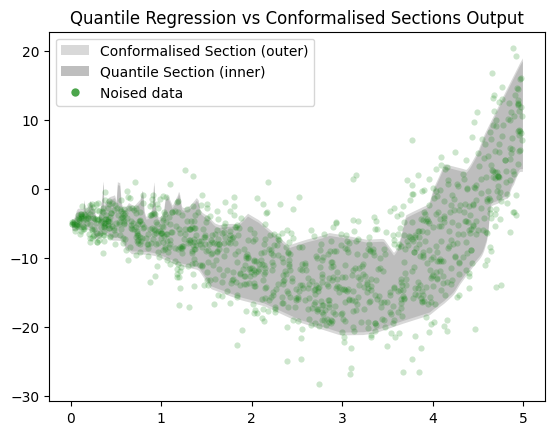

In [29]:
# pred_lo = model.apply(params_lo, x_calib)
# pred_hi = model.apply(params_hi, x_calib)
# plt.scatter(x_calib, y_calib_noised, label='Noised data', c='g', alpha=0.2, linewidths=0, s=20)
# plt.fill_between(x_calib[:, 0], pred_lo[:, 0], pred_hi[:, 0], zorder=-10, color='gray', alpha=0.3, linewidth=0)
# plt.fill_between(x_calib[:, 0], pred_lo[:, 0] - q_hat, pred_hi[:, 0] + q_hat, zorder=-10, color='gray', alpha=0.3, linewidth=0)
# plt.title('Quantile Regression vs Conformalised Sections Output')

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# your existing plotting…
pred_lo = model.apply(params_lo, x_calib)
pred_hi = model.apply(params_hi, x_calib)
plt.scatter(x_calib, y_calib_noised, label='Noised data',
            c='g', alpha=0.2, linewidths=0, s=20)
plt.fill_between(x_calib[:, 0], pred_lo[:, 0], pred_hi[:, 0],
                 color='gray', alpha=0.3, zorder=-10, linewidth=0)
plt.fill_between(x_calib[:, 0],
                 pred_lo[:, 0] - q_hat,
                 pred_hi[:, 0] + q_hat,
                 color='gray', alpha=0.3, zorder=-10, linewidth=0)
plt.title('Quantile Regression vs Conformalised Sections Output')

# compute the RGBA for single and double overlap:
base_rgb = (0.5, 0.5, 0.5)  # matplotlib ‘gray’ = 50% gray
alpha_single = 0.3
alpha_double = alpha_single + alpha_single * (1 - alpha_single)  # = 0.51

outer_rgba = (*base_rgb, alpha_single)
inner_rgba = (*base_rgb, alpha_double)

# create legend patches
handles = [
    Patch(facecolor=outer_rgba, edgecolor='none',
          label='Conformalised Section (outer)'),
    Patch(facecolor=inner_rgba, edgecolor='none',
          label='Quantile Section (inner)'),
    Line2D([], [], marker='o', linestyle='None',
           markerfacecolor='g', markeredgecolor='none',
           alpha=0.7, markersize=6, label='Noised data')
]

plt.legend(handles=handles, loc='upper left')
plt.show()

## Now assess the underlying coverage

In [30]:
# generate test data to evaluate the true performance
n_test = 500
# x_test = jnp.linspace(0, 5, num=n_test).reshape((-1, 1))
test_key = jax.random.key(3)
x_test = jax.random.uniform(test_key, shape=(n_test, 1), minval=0, maxval=5)
x_test = jnp.sort(x_test, axis=0)

# use the model to generate predicted quantiles
pred_lo: jax.Array = model.apply(params_lo, x_test) # type: ignore
pred_hi: jax.Array = model.apply(params_hi, x_test) # type: ignore

# remove the batch dimension from everything for plotting
x_test = x_test[:, 0]
pred_lo = pred_lo[:, 0]
pred_hi = pred_hi[:, 0]

# generate the true data
noise_rng = jax.random.split(jax.random.key(42), n_test)
true_quantile_offset = jnp.sqrt(x_test) * noise_amp * std_radius(1 - alpha)
y_test_true = f_batch(x_test)
y_test_noised = f_noise_batch(x_test, noise_rng)

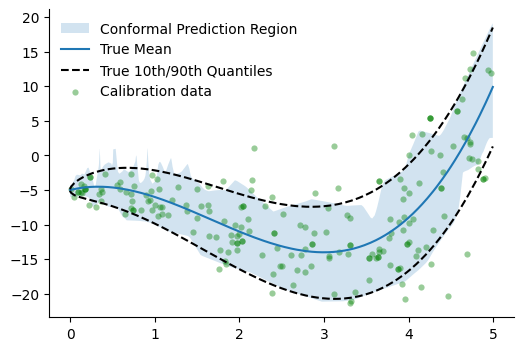

In [44]:
# fill the conformal region
# plt.fill_between(x_test, pred_lo, pred_hi, alpha=0.2, label='Model Prediction')
plt.fill_between(x_test,
                 pred_lo - q_hat,
                 pred_hi + q_hat,
                 alpha=0.2,
                 label='Conformal Prediction Region')

# true mean
plt.plot(x_test, y_test_true, label='True Mean')

# dashed black quantile lines: label only the first so they collapse into one entry
plt.plot(x_test,
         y_test_true + true_quantile_offset,
         color='k',
         linestyle='--',
         label=r'True 10th/90th Quantiles')
plt.plot(x_test,
         y_test_true - true_quantile_offset,
         color='k',
         linestyle='--',
         label='_nolegend_')  # suppress second legend entry

# plt.title(f'Conformalized Quantile Regression with {n_train} training samples')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plot some data points as example
key = jax.random.key(42)
ix = jax.random.choice(key, len(x_calib), shape=(200,))
plt.scatter(x_calib[ix], y_calib_noised[ix], label='Calibration data',
            c='g', alpha=0.4, linewidths=0, s=20)

plt.legend(frameon=False)
save_dir = f'../../results/figures/basic_conformal_regression/ntrain_{n_train}_ncalib_{n_calib}.pdf'
plt.gcf().set_size_inches(6, 4)
plt.savefig(save_dir, format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
n_true = 0
for idx in range(n_test):
    lo_t, hi_t, y_t = pred_lo[idx], pred_hi[idx], y_test_noised[idx]
    if y_t >= (hi_t + q_hat) or y_t <= (lo_t - q_hat):
        continue
    n_true += 1

coverage = n_true / n_test
coverage
# print(f'{n_true=}, {n_test=}, {n_true/n_test=}')

0.82